##### Import some useful packages

In [137]:
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import ffn
import arch
import statsmodels.api as sm
from scipy import optimize as scopt
from scipy import linalg as la
import yfinance as fyf
import getFamaFrenchFactors as gff
import pandas_datareader.data as web

##### Create a portfolio consists of S&P 500 Index, 20 yrs Treasury, 1-3 yrs Treasury, Apple, and Google, and get theie quotes for the past 15 years

[*********************100%***********************]  2 of 2 completed


,spy,tlt,shy,AAPL,GOOGL
Date,,,,,
2005-01-03,88.533607,53.163208,62.333759,4.520714,101.456459
2005-01-04,87.451752,52.606022,62.195969,4.567143,97.347351
2005-01-05,86.848251,52.887627,62.211266,4.607143,96.851852
2005-01-06,87.289810,52.923534,62.241951,4.610714,94.369370
2005-01-07,87.164726,53.043388,62.249546,4.946429,97.022018


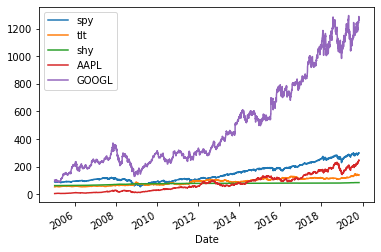

In [138]:
price = ffn.get(['spy','tlt','shy'],start = '2005-01-01', end='2019-10-31')
my_stocks = ['AAPL','GOOGL']
# Get real-time quotes frmo yahoo finance
my_stocks_closes = fyf.download(my_stocks, start = '2005-01-01',end='2019-10-31')['Close']

# Merge two DataFrames
prices = pd.concat([price,my_stocks_closes],axis=1)
prices.plot(linestyle = '-')
# plt.show()
prices.head()

##### Convert the prices into daily returns for further computations and plot the daily returns for comparison

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12fc7a5f8>,
      dtype=object)

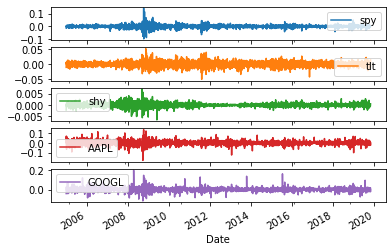

In [139]:
# Drop data with no value
perc_rets = prices.to_returns().dropna()
perc_rets.plot(subplots=True)

##### Visualize the monthly returns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x129248518>,
      dtype=object)

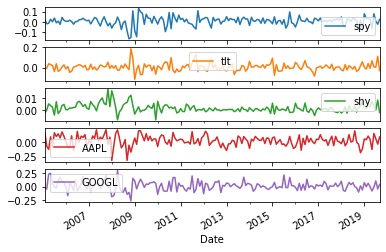

In [140]:
# Calculate the sample prices and returns with ffn method
# monthly_prices = ffn.core.asfreq_actual(prices, 'M')
monthly_prices = prices.asfreq('M',method='bfill')
monthly_rets = monthly_prices.to_returns().dropna()
monthly_rets.plot(subplots=True)


##### Display raw performances for difference assets

In [141]:
stats = prices.calc_stats()
stats.display()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ffn/core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


Stat                 spy         tlt         shy         AAPL        GOOGL
-------------------  ----------  ----------  ----------  ----------  ----------
Start                2005-01-03  2005-01-03  2005-01-03  2005-01-03  2005-01-03
End                  2019-10-30  2019-10-30  2019-10-30  2019-10-30  2019-10-30
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         239.85%     159.29%     34.69%      5281.01%    1142.60%
Daily Sharpe         0.54        0.54        1.51        0.99        0.73
Daily Sortino        0.84        0.91        2.60        1.66        1.24
CAGR                 8.60%       6.64%       2.03%       30.86%      18.53%
Max Drawdown         -55.19%     -26.59%     -2.23%      -60.87%     -65.29%
Calmar Ratio         0.16        0.25        0.91        0.51        0.28

MTD                  2.48%       -2.43%      0.14%       8.61%       3.24%
3m                   1.60%       6.30%       0.77%       16.51%      2.66%
6m   

##### Define functions for calculating the Sharpe Ratio, Volatility, and Optimaztion functions for maximizing Sharpe Ratio & minimizing global variance

In [142]:
# Get all needed variables
def get_p_moments(weights, returns, cov_type=None, risk_free=0, f_factor=1):
    
    weights = sp.asarray(weights)
    mu = returns.mean(axis=0) * f_factor
    exp_ret = mu.dot(weights)
    
    if cov_type is None:
        cov = returns.cov()
    else:
        cov = sp.asarray(cov_type)
    vol = sp.sqrt(sp.dot(weights.T, sp.dot(cov, weights))) * sp.sqrt(f_factor)
    return exp_ret, cov, vol, weights

# Get negative Sharpe Ratio
def max_sharpe_ratio(weights, returns, cov_type=None, risk_free=0, f_factor=1):
    exp_ret, cov, vol, weights = get_p_moments(weights, returns, cov_type, risk_free, f_factor)
    return -(exp_ret - risk_free) / vol

# Get volatility
def min_volatility(weights, returns, cov_type=None, risk_free=0, f_factor=1):
    exp_ret, cov, vol, weights = get_p_moments(weights, returns, cov_type, risk_free, f_factor)
    return vol

# Minimimize the global volatility, which is to minimize global variance
def gmv_portfolio(returns, cov_type=None, risk_free=0, f_factor=1, n_assets=None, set_bounds=[0.0, 1.0]):
    if n_assets is None:
        num_assets = returns.shape[1]
    else:
        num_assets = n_assets
    args = (returns, cov_type, risk_free, f_factor)
    constraints = ({'type': 'eq', 'fun': lambda x: sp.sum(x) - 1})
    bound = (set_bounds[0], set_bounds[1])
    bounds = tuple(bound for asset in range(num_assets))
    w0 = sp.ones(num_assets)/num_assets
    result = scopt.minimize(min_volatility, w0, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    w1 = result.x
    exp_ret, cov, vol, w1 = get_p_moments(w1, returns, cov_type, risk_free, f_factor)
    return exp_ret, cov, vol, w1

# Minimimize the negative Sharpe Ratio, which is to get Maximized positive Sharpe Ratio
def sr_portfolio(returns, cov_type=None, risk_free=0, f_factor=1, n_assets=None, set_bounds=[0.0, 1.0]):
    if n_assets is None:
        num_assets = returns.shape[1]
    else:
        num_assets = n_assets
    args = (returns, cov_type, risk_free, f_factor)
    constraints = ({'type': 'eq', 'fun': lambda x: sp.sum(x) - 1})
    bound = (set_bounds[0], set_bounds[1])
    bounds = tuple(bound for asset in range(num_assets))
    w0 = sp.ones(num_assets)/num_assets
    result = scopt.minimize(max_sharpe_ratio, w0, args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    w1 = result.x
    exp_ret, cov, vol, w1 = get_p_moments(w1, returns, cov_type, risk_free, f_factor)
    return exp_ret, cov, vol, w1

##### Define functions to calculate realized monthly covariance,  Multi-factor Factor Model covariance, Fama-French 3-factor Model covariance

In [143]:
# function to calculate monthly covariance
def extract_cov(xdata):
    cov_mat = np.cov(xdata,rowvar=False)
    return cov_mat

# function to calculate monthly covariance from 2-factor model
def factor_cov(xdata,n_factors=2):
    if n_factors < 2:
        raise ValueError('Must Select at Least 2 Factors')
    x_cov = sp.cov(xdata, rowvar=False)

    # and then apply the eigenvalue decomposition
    [d, v] = la.eigh(x_cov)

    # Need to reverse the order of the eigenvalues and the eigenvectors
    d = d[::-1]
    v = v[:, ::-1]

    # Now construct our factors
    d_mat = sp.identity(5)
    sp.fill_diagonal(d_mat, d)
    
    beta_all = sp.dot(v, sp.sqrt(d_mat)).T
    # and then from the factors
    
    beta_f = sp.dot(v[:, :(n_factors-1)], sp.sqrt(d_mat[:(n_factors-1), :(n_factors-1)])).T
    systematic = sp.dot(beta_f.T, beta_f)
    idiosyncratic = sp.diagonal(x_cov - sp.dot(beta_f.T, beta_f))
    Sigma = systematic + idiosyncratic
    
    return Sigma

# Read the FF 3 factors
fama_3 = gff.famaFrench3Factor(frequency='m') 
get_dates1 =  fama_3['date_ff_factors'] <= monthly_rets.index[-1]
get_dates2 = monthly_rets.index[0] <= fama_3['date_ff_factors']
get_dates = get_dates1 & get_dates2
fff = fama_3[get_dates]
fff.index = monthly_rets.index
fff = fff[['Mkt-RF', 'SMB', 'HML']]

# function to calculate monthly covariance from Fama French 3-factor model
def ff_factor_monthly(y_data, x_data, use_diag=False):
    out = sm.OLS(y_data, sm.add_constant(x_data)).fit()
    betas = sp.asarray(out.params[1:])
    F_cov = sp.cov(x_data, rowvar=False)
    U_cov = sp.cov(out.resid, rowvar=False) # do not impose diagonality yet
    if use_diag is True: # but impose it when asked for 
        U_var = sp.diagonal(U_cov)
        U_cov = sp.identity(y_data.shape[1])
        sp.fill_diagonal(U_cov, U_var)
    C_cov = sp.dot(sp.dot(betas.T, F_cov), betas) + U_cov
    return C_cov

# get the monthly realized covariance
r_cov = perc_rets.groupby([perc_rets.index.year, perc_rets.index.month]).apply(lambda x: extract_cov(x))
f_cov = perc_rets.groupby([perc_rets.index.year, perc_rets.index.month]).apply(lambda x: factor_cov(x))
# allign the date index of covariance dataframe to the monthly returns dataframe
r_cov = r_cov.iloc[2:]
f_cov = f_cov.iloc[2:]
r_cov.index = monthly_rets.index
f_cov.index = monthly_rets.index

# last month is missing from the FF factors so align everything
# monthly_rets = monthly_rets.iloc[:-1]
# r_cov = r_cov.iloc[:-1]
# f_cov = f_cov.iloc[:-1]

/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.cov is deprecated and will be removed in SciPy 2.0.0, use numpy.cov instead
  # Remove the CWD from sys.path while we load stuff.
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:20: DeprecationWarning: scipy.identity is deprecated and will be removed in SciPy 2.0.0, use numpy.identity instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:21: DeprecationWarning: scipy.fill_diagonal is deprecated and will be removed in SciPy 2.0.0, use numpy.fill_diagonal instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.dot is deprecated and will be removed 

##### Get and compute the LIBOR rate as a benchmark for actual risk free rate

In [144]:
# Lets get the 1-month Libor rate as well for use as the benchmark for risk free rate
libor = web.DataReader('USD1MTD156N', 'fred', perc_rets.index[0], perc_rets.index[-1])
# We need to convert the Libor rate into monthly frequency
libor = (libor/100)/252
libor_monthly = libor.resample('M').agg(lambda x: sp.prod(x+1)-1)
# Correct the dates of the monthly libor rate
libor_monthly = libor_monthly.iloc[1:-1]

/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.prod is deprecated and will be removed in SciPy 2.0.0, use numpy.prod instead
  """


##### Visualize the LIBOR rate 

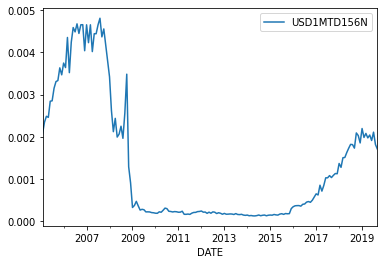

In [145]:
libor_monthly.plot()

###### Optimization methods: Global Minimized Variance, Maximized Sharpe Ratio
###### Covariance types: Sample monthly covariance based on monthly returns, Realized monthly covariance based on daily returns, Sample monthly covariance from 2-factor model, Realized monthly covariance from 2-factor model, Sample covariance based on Fama-French 3-factor model
##### Create DataFrames to store returns for different combinations of 2 optimization methods & 5 types covariance.

In [146]:
loop_index = r_cov.index[24:]

In [147]:
# Create a DataFrame to store all the returns for different combinations
store_port_rets = pd.DataFrame(data=None, index=loop_index, columns = ['GMV-Plain', 'GMV-Realized','SR-Plain', 'SR-Realized','GMV-Plain-2Factor','GMV-Realized-2Factor','SR-Plain-2Factor','SR-Realized-2Factor', 'GMV-Plain-Fama', 'SR-Plain-Fama'])

# Create Dataframe to store returns for GMV + Sample Covariance
store_weights_gmv_plain = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for GMV + Realized Covariance
store_weights_gmv_real = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for SR + Sample Covariance
store_weights_sr_plain = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for SR + Realized Covariance
store_weights_sr_real = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for GMV + Sample 2-factor Covariance
store_weights_gmv_plain_factor = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for GMV + Realized 2-factor Covariance
store_weights_gmv_real_factor = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for SR + Sample 2-factor Covariance 
store_weights_sr_plain_factor = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for SR + Realized 2-factor Covariance 
store_weights_sr_real_factor = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for GMV + Sample FF-factor Covariance
store_weights_gmv_ff_factor = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
# Create Dataframe to store returns for SR + Sample FF-factor Covariance
store_weights_sr_ff_factor = pd.DataFrame(data=None, index=loop_index, columns = ['SPY', 'TLT', 'SHY','AAPL','GOOGL'])

###### Start Computing

In [148]:
# Initialize a time frame (24 months) for rolling window 
roll = 24

# Set a flag for the use of actual LIBOR rate
libor_average = False

# Set a flag for the use of rolling window
do_roll = True

# Define boundary for asset's weight
port_bounds = [0, 1]

# Set the looping index
loop_index = r_cov.index[roll:]

for i in loop_index:
    # use recursive window as default
    i_rets = monthly_rets.iloc[monthly_rets.index <= i]
    i_fff = fff.iloc[monthly_rets.index <= i]
    i_libor = libor_monthly.iloc[monthly_rets.index <= i]
    
    # if use rolling window 
    if do_roll is True:
        i_rets = i_rets.iloc[-roll:]
        i_fff = i_fff.iloc[-roll:]
        i_libor = i_libor.iloc[-roll:]
    # if use floating LIBOR instead of fixed risk-free rate, calculate the average of LIBOR up until now
    if libor_average is True:
        i_rf = i_libor.mean(axis=0)
    # if not use floating LIBOR, used the last LIBOR as a fixed risk-free rate
    elif libor_average is False:
        i_rf = i_libor.iloc[-1]
    # convert into array
    i_rf = sp.asarray(i_rf)
    
    # get realized monthly covariance of current month
    i_r_cov = r_cov.iloc[r_cov.index == i]
    i_r_cov = sp.asarray(sp.vstack(i_r_cov))
    # get realized monthly covariance based on 2-factor model of current month 
    i_r_fcov = f_cov.iloc[f_cov.index == i]
    i_r_fcov = sp.asarray(sp.vstack(i_r_cov))
    # get sample monthly covariance based on 2-factor model of cummulative months 
    i_fcov = factor_cov(i_rets)
    #get sample monthly covariance based on FF-factor model of cummulative months
    ff_fcov = ff_factor_monthly(i_rets, i_fff, use_diag=False)
    

    # store the corresponding results with different combinations of optimization methods and covaraince types
    #
    [er_0, cov_0, vol_0, weights_0] = gmv_portfolio(i_rets, cov_type=None, risk_free=i_rf, f_factor=12, 
                                                    n_assets=None, set_bounds=port_bounds)
    [er_1, cov_1, vol_1, weights_1] = gmv_portfolio(i_rets, cov_type=i_r_cov, risk_free=i_rf, f_factor=12, 
                                                    n_assets=None, set_bounds=port_bounds)
    #
    [er_2, cov_2, vol_2, weights_2] = sr_portfolio(i_rets, cov_type=None, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    [er_3, cov_3, vol_3, weights_3] = sr_portfolio(i_rets, cov_type=i_r_cov, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    #
    [er_4, cov_4, vol_4, weights_4] = gmv_portfolio(i_rets, cov_type=i_r_fcov, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    [er_5, cov_5, vol_5, weights_5] = gmv_portfolio(i_rets, cov_type=i_fcov, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    #
    [er_6, cov_6, vol_6, weights_6] = sr_portfolio(i_rets, cov_type=i_r_fcov, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    [er_7, cov_7, vol_7, weights_7] = sr_portfolio(i_rets, cov_type=i_fcov, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    
    [er_8, cov_8, vol_8, weights_8] = gmv_portfolio(i_rets, cov_type=ff_fcov, risk_free=i_rf, f_factor=12, 
                                                    n_assets=None, set_bounds=port_bounds)
    [er_9, cov_9, vol_9, weights_9] = sr_portfolio(i_rets, cov_type=ff_fcov, risk_free=i_rf, f_factor=12, 
                                                   n_assets=None, set_bounds=port_bounds)
    
    weights_0_pd = pd.DataFrame(weights_0.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_gmv_plain.iloc[store_weights_gmv_plain.index == i] = weights_0_pd
    
    weights_1_pd = pd.DataFrame(weights_1.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_gmv_real.iloc[store_weights_gmv_real.index == i] = weights_1_pd
    
    weights_2_pd = pd.DataFrame(weights_2.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_sr_plain.iloc[store_weights_sr_plain.index == i] = weights_2_pd
    
    weights_3_pd = pd.DataFrame(weights_3.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_sr_real.iloc[store_weights_sr_real.index == i] = weights_3_pd
    
    weights_4_pd = pd.DataFrame(weights_4.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_gmv_plain_factor.iloc[store_weights_gmv_plain_factor.index == i] = weights_4_pd
    
    weights_5_pd = pd.DataFrame(weights_5.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_gmv_real_factor.iloc[store_weights_gmv_real_factor.index == i] = weights_5_pd
    
    weights_6_pd = pd.DataFrame(weights_6.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_sr_plain_factor.iloc[store_weights_sr_plain_factor.index == i] = weights_6_pd
    
    weights_7_pd = pd.DataFrame(weights_7.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_sr_real_factor.iloc[store_weights_sr_real_factor.index == i] = weights_7_pd
    
    weights_8_pd = pd.DataFrame(weights_8.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_gmv_ff_factor.iloc[store_weights_gmv_plain_factor.index == i] = weights_8_pd
    
    weights_9_pd = pd.DataFrame(weights_9.reshape([1,np.size(r_cov.iloc[1],1)]), index=[i], columns=['SPY', 'TLT', 'SHY','AAPL','GOOGL'])
    store_weights_sr_ff_factor.iloc[store_weights_sr_ff_factor.index == i] = weights_9_pd
    
    # calculate rebalancing monthly returns for each combinations
    if i < loop_index[-1]:
        index_next = monthly_rets.iloc[monthly_rets.index > i].index[0]
        rets_next = monthly_rets.iloc[monthly_rets.index > i].iloc[0]
        port_rets_0 = sp.dot(rets_next, weights_0)
        port_rets_1 = sp.dot(rets_next, weights_1)
        port_rets_2 = sp.dot(rets_next, weights_2)
        port_rets_3 = sp.dot(rets_next, weights_3)
        port_rets_4 = sp.dot(rets_next, weights_4)
        port_rets_5 = sp.dot(rets_next, weights_5)
        port_rets_6 = sp.dot(rets_next, weights_6)
        port_rets_7 = sp.dot(rets_next, weights_7)
        port_rets_8 = sp.dot(rets_next, weights_6)
        port_rets_9 = sp.dot(rets_next, weights_7)
        
        # and store them
        port_rets_all = sp.hstack([port_rets_0, port_rets_1, port_rets_2,port_rets_3, port_rets_4, port_rets_5, port_rets_6, port_rets_7, port_rets_8, port_rets_9]).reshape([1, 10])
        port_rets_all = pd.DataFrame(port_rets_all, index=[index_next], columns = store_port_rets.columns)
        store_port_rets.iloc[store_port_rets.index == index_next] = port_rets_all 

/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.vstack is deprecated and will be removed in SciPy 2.0.0, use numpy.vstack instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:38: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:41: DeprecationWarning: scipy.vstack is deprecated and will be removed in SciPy 2.0.0, use numpy.vstack instead
/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:41: DeprecationWarning: scipy.asarray is deprecated and will be removed in SciPy 2.0.0, use numpy.asarray instead
/Users/ZiyanLai/Library/

##### Visualize and compare monthly average returns

In [149]:
# drop the empty returns
store_port_rets = store_port_rets.dropna()
# Calculate the average
print(store_port_rets.mean())

GMV-Plain               0.001651
GMV-Realized            0.001783
SR-Plain                0.002604
SR-Realized             0.004450
GMV-Plain-2Factor       0.001783
GMV-Realized-2Factor    0.001560
SR-Plain-2Factor        0.004450
SR-Realized-2Factor     0.010390
GMV-Plain-Fama          0.004450
SR-Plain-Fama           0.010390
dtype: float64


##### Define functinos to calculate annualized statistics, including Expected Return, Volatility, Sharpe Ratio, Total Return, and Max Drawdown

In [127]:
rf_rate = 0.015

def max_dropdown(cum_ret):
    max_cum_ret = (cum_ret + 1).cummax(axis=0)
    drawdowns = ((cum_ret + 1) / max_cum_ret) - 1
    return drawdowns.min(axis=0)

def performance(rets, f_factor, risk_free, target_r=0):
    mu = rets.mean() * f_factor
    sd = rets.std() * sp.sqrt(f_factor)
    sr = (mu -risk_free)/ sd
    cum_ret = (rets+1).cumprod(axis=0) - 1
    max_d = max_dropdown(cum_ret)
    stats = pd.DataFrame([mu, sd, sr, cum_ret.iloc[-1], max_d])
    stats.index = ['Mean', 'Std Dev', 'Sharpe Ratio', 'Total Return', 'Max Drawdown']
    return stats.transpose(), cum_ret

# add assets' self-performance 
store_port_bench = pd.concat([store_port_rets, monthly_rets.loc[store_port_rets.index]], axis=1)

# store the results
[stats, cum_rets] = performance(store_port_bench, 12, rf_rate, 0)



/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  # Remove the CWD from sys.path while we load stuff.


In [128]:
stats

,Mean,Std Dev,Sharpe Ratio,Total Return,Max Drawdown
GMV-Plain,0.019810,0.011109,0.432972,0.281844,-0.010326
GMV-Realized,0.021398,0.010942,0.584742,0.307710,-0.009489
SR-Plain,0.031252,0.040270,0.403580,0.466132,-0.113406
SR-Realized,0.053398,0.036557,1.050374,0.938661,-0.078097
GMV-Plain-2Factor,0.021398,0.010942,0.584742,0.307710,-0.009489
GMV-Realized-2Factor,0.018717,0.012808,0.290252,0.264056,-0.009859
SR-Plain-2Factor,0.053398,0.036557,1.050374,0.938661,-0.078097
SR-Realized-2Factor,0.124682,0.186213,0.589017,2.810897,-0.349060
GMV-Plain-Fama,0.053398,0.036557,1.050374,0.938661,-0.078097
SR-Plain-Fama,0.124682,0.186213,0.589017,2.810897,-0.349060


##### From the stats, we observed: 
##### 1. Maximized Sharpe Ratio optimization method gives higher expected returns and higher volitality than GMV optimization method, which make sense, since only when the expected return is high enough, it can be able to conpensate the increasing volatility to yield a higher Sharpe Ratio.
##### 2. The 2-factor model and the Fama-French 3-factor model give slightly higher volatility, which is probably caused by the characteristics of factor models: it gives more reliable, therefore higher volatilities.
##### 3. Realized monthly covariance gives higher returns and higher volatilities in general. It's because we are focusing on current timestep each time, while the sample covariance is based on cumulative datas from the previous months, so the characteristics of the portfolio are gradually smoothed out . This is also the reason why realized covariance and returns are more precise, more reliable, and yield a better performance in portfolio optimization. 

In [129]:
cum_rets.mean()

GMV-Plain               0.164960
GMV-Realized            0.174442
SR-Plain                0.280638
SR-Realized             0.429522
GMV-Plain-2Factor       0.174442
GMV-Realized-2Factor    0.172434
SR-Plain-2Factor        0.429522
SR-Realized-2Factor     1.508568
GMV-Plain-Fama          0.429522
SR-Plain-Fama           1.508568
spy                     0.475131
tlt                     0.598225
shy                     0.172444
AAPL                    6.257040
GOOGL                   1.444385
dtype: float64

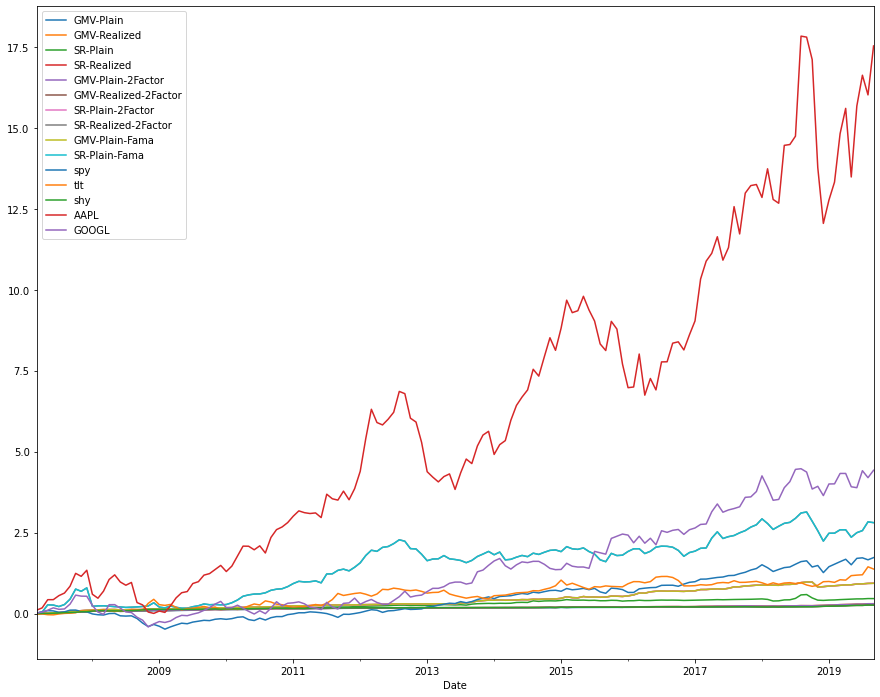

In [130]:
cum_rets.plot(figsize=(15,12))

##### By plotting all the cumulative returns in one graph, we observe that the factor models with the combination of Share Ratio maximized & realized covariance yields the highest cumulative returns, along with higher fluctuations; while the GMV optimizations yield lower cumulative returns, and smaller fluctuations as well. 
##### This is because the goal of GMV is exactly to miminize the volatility, while SR focuses on maximizing Sharpe Ratios, so cannot garantee a lower volatility. 

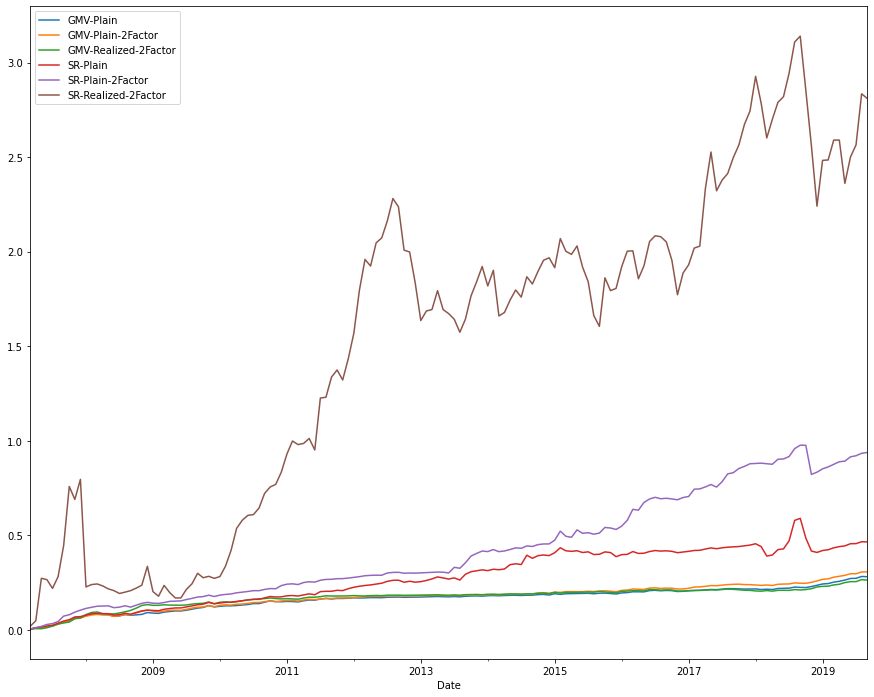

In [131]:
cum_rets[['GMV-Plain','GMV-Plain-2Factor','GMV-Realized-2Factor','SR-Plain','SR-Plain-2Factor','SR-Realized-2Factor']].plot(figsize=(15,12))

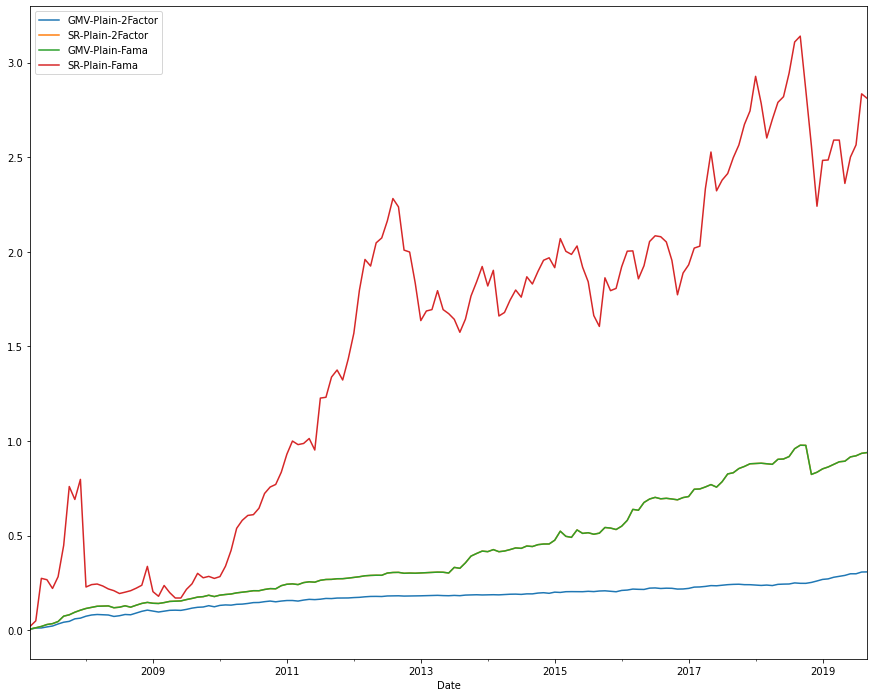

In [132]:
cum_rets[['GMV-Plain-2Factor','SR-Plain-2Factor','GMV-Plain-Fama','SR-Plain-Fama']].plot(figsize=(15,12))

##### We observed that the minimized variance optimization yields significantly smaller volatility, however, along with a much smaller return.

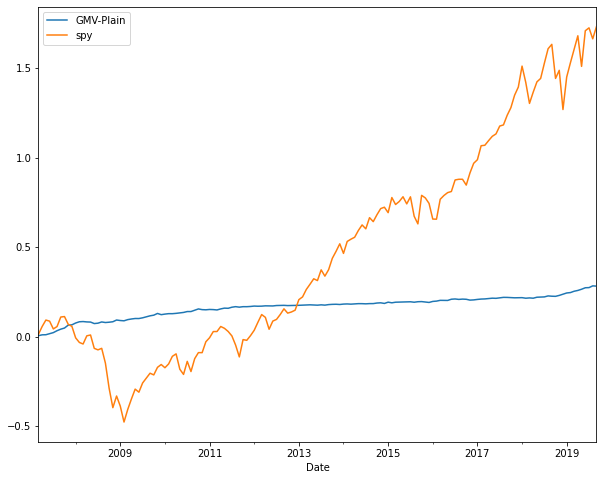

In [133]:
cum_rets[['GMV-Plain', 'spy']].plot(figsize=(10,8))

##### We observe that using Max-Sharpe-Ratio optimization, the realized return almost follows the pattern with the plain sample return. The realized return is generally higher at all time periods. Here I believe the realized return is more reliable, since it focuses on smaller timeframs, therefore gives more accurate result.

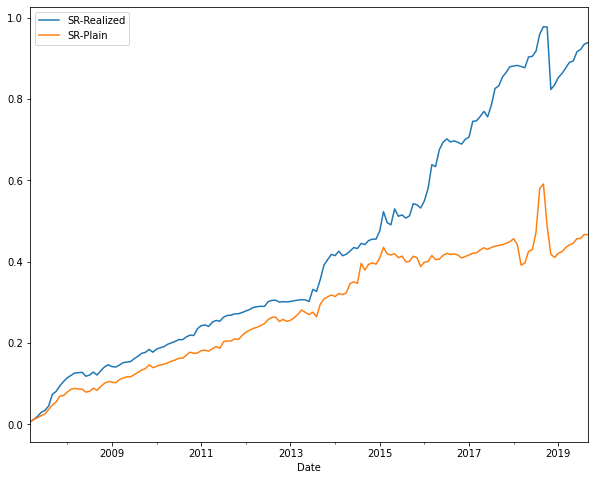

In [136]:
cum_rets[['SR-Realized', 'SR-Plain']].plot(figsize=(10,8))

##### Here we display the weight allocation given by different combinations of optimization methods and covariance types:

In [135]:
weights = sp.hstack([np.round(weights_0,2),np.round(weights_1,2),np.round(weights_2,2),np.round(weights_3,2),np.round(weights_4,2),np.round(weights_5,2),np.round(weights_6,2),np.round(weights_7,2),np.round(weights_8,2),np.round(weights_9,2)]).reshape([10,np.size(r_cov.iloc[1],1)])
weights = pd.DataFrame(data=weights, columns=('spy','tlt','shy','AAPL','GOOGL'), index=store_port_rets.columns)
print(weights)

                       spy   tlt   shy  AAPL  GOOGL
GMV-Plain             0.02  0.00  0.97  0.00   0.01
GMV-Realized          0.03  0.00  0.96  0.01   0.00
SR-Plain              0.02  0.00  0.95  0.01   0.02
SR-Realized           0.02  0.00  0.94  0.04   0.00
GMV-Plain-2Factor     0.03  0.00  0.96  0.01   0.00
GMV-Realized-2Factor  0.00  0.00  1.00  0.00   0.00
SR-Plain-2Factor      0.02  0.00  0.94  0.04   0.00
SR-Realized-2Factor   0.00  0.74  0.00  0.26   0.00
GMV-Plain-Fama        0.02  0.00  0.97  0.00   0.01
SR-Plain-Fama         0.02  0.00  0.95  0.01   0.02


/Users/ZiyanLai/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:1: DeprecationWarning: scipy.hstack is deprecated and will be removed in SciPy 2.0.0, use numpy.hstack instead
  """Entry point for launching an IPython kernel.
